# **Setup By Importing Needed Libraries**

In [1]:
!pip install fasttext
import fasttext
from huggingface_hub import hf_hub_download
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import roc_auc_score
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 688.0 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.11.1-py3-none-any.whl (227 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4199777 sha256=afcd6b245f974918d502eddc7513301be977ec731c19ebf8fa50fc9a466fa337
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# **Load Embeddings**

- Load Fasttext embedding vectors for Arabic words using Hugging Face.

In [2]:
embedding_model_path = hf_hub_download(repo_id="facebook/fasttext-ar-vectors", filename="model.bin")
embedding_model = fasttext.load_model(embedding_model_path)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.bin:   0%|          | 0.00/7.25G [00:00<?, ?B/s]

# **Extract The Data**

**a. Extract Function**
- Using bs4 and requests libraries to use web scraping for data collection.
- Use data from eg.dowwer.com to get names for addresses or districts from all governerates in Egypt.
- Transform the collected data to dataframe and return it after merging it with the unique data that are not presented in it from Cairo.txt file.

In [3]:
def extract_data(url, table_columns, cairo_districts):
    """
    Extracts data from a specified URL containing district information,
    assigns labels based on Cairo districts, and compiles the data into a DataFrame.

    Parameters:
    - url (str): The URL from which to extract district information.
    - table_columns (list): List of column names for the resulting DataFrame.
    - cairo_districts (str): Path to a text file containing a list of Cairo districts.

    Returns:
    - pd.DataFrame: A DataFrame containing the extracted data with columns specified in table_columns.
    """

    df = pd.DataFrame(columns=table_columns)
    page = requests.get(url).text
    data = BeautifulSoup(page, 'html.parser')
    uls = data.find_all('ul', class_='link')
    h3 = data.find_all('h3')

    for i, ul in enumerate(uls):
        list_of_districts = ul.find_all('li')
        label = 1 if h3[i].a.contents[0] == 'القاهرة' else 0
        for i, district in enumerate(list_of_districts):
            if i == len(list_of_districts) - 1:
                break
            data_dict = {
                "district_name": district.a.contents[0],
                'label': label
            }
            df_temp = pd.DataFrame(data_dict, index=[0])
            df = pd.concat([df, df_temp], ignore_index=True)

    with open('Cairo.txt', 'r') as f:
        list_ = [line[:-1] for line in f.readlines()]

    subset = [district for district, label in zip(df['district_name'], df['label']) if label == 1]
    difference_list = list(set(list_) - set(subset))

    for district in difference_list:
        data_dict = {
            "district_name": district,
            'label': 1
        }
        df_temp = pd.DataFrame(data_dict, index=[0])
        df = pd.concat([df, df_temp], ignore_index=True)

    return df

**b. Apply extract method**

- Send url and table attributes to the function and print the returned dataframe head.
- Print the length pf the dataset
- Note that you need to upload the textfile Cairo.txt

In [4]:
url = "https://eg.dowwr.com/regions/"
table_columns = ['district_name', 'label']
df = extract_data(url, table_columns, 'Cairo.txt')
df.head()

,district_name,label
0,ابو الريش,0
1,ابو سمبل,0
2,ادفو,0
3,البصيلية,0
4,الرديسية,0


In [5]:
len(df)

413

- Save the dataframe to csv file

In [6]:
df.to_csv('district_data.csv', encoding='utf-8', index=False)

# **Scikit-Learn Models**

# **Transform The Data**

**a. Transform Function**

- Tokenize the data and load word embeddings from the embeddings pretrained model.
- For each district take the mean of embeddings for all it's words.
- Return the transformed dataFrame

In [7]:
def transform(data):
    """
    Transforms district data by computing embeddings for each district name.

    Parameters:
    - data (pd.DataFrame): DataFrame containing district data.

    Returns:
    - pd.DataFrame: DataFrame containing embeddings for each district along with labels.
    - list: List of tokenized district names.
    """

    district_tokens = []
    embeddings = []

    for district in data['district_name']:
        tokens = word_tokenize(district)
        embeddings.append(np.mean([embedding_model.get_word_vector(token) for token in tokens], axis=0))
        district_tokens.append(tokens)

    df_embeddings = pd.DataFrame(embeddings)
    df_embeddings['label'] = data['label']

    return df_embeddings, district_tokens

**b. Apply Transformation**

In [8]:
transformed_df, district_tokens = transform(df)

In [9]:
transformed_df.head()

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,label
0,0.020113,0.038619,-0.025801,0.028731,0.232983,-0.003282,0.075591,0.097136,-0.006230,-0.070113,...,-0.016309,-0.058354,0.012242,-0.011040,-0.019971,0.176365,0.025988,-0.077671,0.035623,0
1,-0.036470,-0.014833,0.039275,0.067893,0.284031,-0.046144,0.121496,0.122714,-0.040895,-0.155957,...,-0.073423,0.003372,0.003084,0.056712,0.052449,0.106780,0.033557,-0.021952,0.049117,0
2,0.077119,-0.024226,0.077301,0.049764,0.320695,-0.023371,0.101289,-0.057145,-0.076402,0.040142,...,-0.070357,0.051376,-0.010567,0.048291,0.026196,-0.025980,0.087627,0.002383,0.072401,0
3,0.077384,-0.013852,0.051879,0.085105,0.073722,0.009531,-0.022815,0.020477,0.011879,-0.034024,...,-0.023587,-0.011348,-0.004207,-0.028661,0.027502,0.049723,-0.024311,-0.041588,-0.019317,0
4,0.046520,-0.034087,-0.034701,0.041161,0.076133,0.010586,-0.001144,0.054442,-0.023870,-0.060203,...,-0.028294,-0.022261,0.037960,-0.029681,-0.004084,0.057400,0.029789,-0.021884,0.027497,0


- Save transformed data to csv file.

In [10]:
transformed_df.to_csv('transformed_data.csv', index = False)

## **Training and Evaluate The Models**

**a. Split**

- Split The dataset into training and testing datasets

In [11]:
def split(data):
    """
    Split the input data into training and testing sets.

    Parameters:
    - data (pd.DataFrame): Input DataFrame containing features and labels.

    Returns:
    - tuple: A tuple containing X_train, X_test, y_train, and y_test.
      - X_train (np.array): Training features.
      - X_test (np.array): Testing features.
      - y_train (np.array): Labels for training.
      - y_test (np.array): Labels for testing.
    """
    X = np.array(data.drop('label', axis=1))
    y = np.array(data['label'], dtype=int)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

    return X_train, X_test, y_train, y_test

In [12]:
X_train, X_test, y_train, y_test = split(transformed_df)

**Fit & Predict**
- Classify using different classification models.
- Show models results

In [13]:
def fit_classification_models(X_train, y_train):
    """
    Fit different classification models on the training data.

    Parameters:
    - X_train (np.array): Training features.
    - y_train (np.array): Labels for training.

    Returns:
    - dict: A dictionary containing fitted classification models.
      - Keys: Model names (e.g., "logistic_regression", "decision_tree").
      - Values: Fitted model instances.
    """
    models_dict = {"logistic_regression": LogisticRegression(random_state=42),
                   "decision_tree": DecisionTreeClassifier(random_state=42),
                   "random_forest": RandomForestClassifier(n_estimators=100, random_state=42),
                   "sgd": SGDClassifier(random_state=42),
                   "svm": SVC(kernel='linear', C=1.0, random_state=42),
                   "xgboost": xgb.XGBClassifier(objective='binary:logistic', random_state=42)}

    for key in models_dict.keys():
        models_dict[key].fit(X_train, y_train)

    return models_dict

In [14]:
models_dict = fit_classification_models(X_train, y_train)

In [15]:
def classification_models_scores(models_dict, X_train, y_train, X_test, y_test):
    """
    Evaluate classification model performance on both training and test sets.

    Parameters:
    - models_dict (dict): Dictionary of fitted classification models.
    - X_train (np.array): Training features.
    - y_train (np.array): Labels for training.
    - X_test (np.array): Test features.
    - y_test (np.array): Labels for testing.
    """
    for key in models_dict.keys():
        # Perform cross-validated predictions on training set
        y_train_predictions = cross_val_predict(models_dict[key], X_train, y_train, cv=3)

        # Predictions on the test set
        y_test_predictions = models_dict[key].predict(X_test)

        # Print evaluation metrics
        print(f"{key} Confusion Matrix: ", confusion_matrix(y_train, y_train_predictions))
        print(f"{key} F1 Score: ", f1_score(y_train, y_train_predictions))
        print(f"{key} ROC Score: ", roc_auc_score(y_train, y_train_predictions))
        print(f"{key} Training Precision Score: ", precision_score(y_train, y_train_predictions))
        print(f"{key} Training Recall Score: ", recall_score(y_train, y_train_predictions))

        print(f"{key} Test Precision Score: ", precision_score(y_test, y_test_predictions))
        print(f"{key} Test Recall Score: ", recall_score(y_test, y_test_predictions))

In [16]:
classification_models_scores(models_dict, X_train, y_train, X_test, y_test)

logistic_regression Confusion Matrix:  [[269   0]
 [ 61   0]]
logistic_regression F1 Score:  0.0
logistic_regression ROC Score:  0.5
logistic_regression Training Precision Score:  0.0
logistic_regression Training Recall Score:  0.0
logistic_regression Test Precision Score:  0.0
logistic_regression Test Recall Score:  0.0
decision_tree Confusion Matrix:  [[234  35]
 [ 43  18]]
decision_tree F1 Score:  0.3157894736842105
decision_tree ROC Score:  0.582485221524773
decision_tree Training Precision Score:  0.33962264150943394
decision_tree Training Recall Score:  0.29508196721311475
decision_tree Test Precision Score:  0.3
decision_tree Test Recall Score:  0.23076923076923078


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


random_forest Confusion Matrix:  [[263   6]
 [ 59   2]]
random_forest F1 Score:  0.05797101449275363
random_forest ROC Score:  0.5052410262660735
random_forest Training Precision Score:  0.25
random_forest Training Recall Score:  0.03278688524590164
random_forest Test Precision Score:  0.0
random_forest Test Recall Score:  0.0
sgd Confusion Matrix:  [[248  21]
 [ 36  25]]
sgd F1 Score:  0.4672897196261682
sgd ROC Score:  0.6658845755378147
sgd Training Precision Score:  0.5434782608695652
sgd Training Recall Score:  0.4098360655737705
sgd Test Precision Score:  0.5714285714285714
sgd Test Recall Score:  0.3076923076923077
svm Confusion Matrix:  [[261   8]
 [ 49  12]]
svm F1 Score:  0.2962962962962963
svm ROC Score:  0.5834907672618685
svm Training Precision Score:  0.6
svm Training Recall Score:  0.19672131147540983


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


svm Test Precision Score:  0.6
svm Test Recall Score:  0.23076923076923078
xgboost Confusion Matrix:  [[255  14]
 [ 41  20]]
xgboost F1 Score:  0.42105263157894735
xgboost ROC Score:  0.6379121213967944
xgboost Training Precision Score:  0.5882352941176471
xgboost Training Recall Score:  0.32786885245901637
xgboost Test Precision Score:  1.0
xgboost Test Recall Score:  0.23076923076923078


- As we can see the ordinary machine learning classification models perform poorly on the dataset.
- So, we can use the benfits of deep learning and neural networks architectures like RNNs to help us.

-----------------------------------------------------------------------------------------------------------------------------

# **RNNs Models**

# **Setup**

In [17]:
import tensorflow as tf
print(tf. __version__)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import GRU
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Bidirectional, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc

2.15.0


# **Preprocessing**

- Define preprocessing functions.
- Define ploting and metrics functions.

In [18]:
def analyze_text_data(data):
    """
    Analyzes a dataset of text data to extract key information.

    Parameters:
    - data (list): A list of text strings.

    Returns:
    - vocab_size (int): Size of the vocabulary.
    - unique_words (set): Set of unique words present in the dataset.
    - max_sequence_length (int): Maximum sequence length in the dataset.
    """
    # Concatenate all text data into a single string
    text_data = ' '.join(data)

    # Tokenize the text to extract unique words and vocabulary size
    tokens = word_tokenize(text_data)
    unique_words = set(tokens)
    vocab_size = len(unique_words) + 1  # Adding 1 for the out-of-vocabulary token

    # Calculate the maximum sequence length in the dataset
    max_sequence_length = -1
    for sentence in data:
        tokens = word_tokenize(sentence)
        max_sequence_length = max(max_sequence_length, len(tokens))

    return vocab_size, unique_words, max_sequence_length

In [19]:
def generate_sequences(data, max_sequence_length):
    """
    Generates sequences from text data using tokenization and padding.

    Parameters:
    - data (list): A list of text strings.
    - max_sequence_length (int): Maximum sequence length for padding.

    Returns:
    - padded_sequences (numpy.ndarray): Padded sequences based on the provided max_sequence_length.
    - word_index (dict): Dictionary mapping words to their corresponding indices.
    """
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(data)
    word_index = tokenizer.word_index

    # Convert text data to sequences and pad them to fit all to the maximum sequence length
    sequences = tokenizer.texts_to_sequences(data)
    padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post', truncating='post')

    return padded_sequences, word_index


In [20]:
def generate_embedding_matrix(embedding_model, vocab_size, word_index, embedding_dim=300):
    """
    Generates an embedding matrix based on a pre-trained embedding model.

    Parameters:
    - embedding_model: The pre-trained embedding model (e.g., Fasttext Arabic model).
    - vocab_size (int): Size of the vocabulary.
    - word_index (dict): Dictionary mapping words to their corresponding indices.
    - embedding_dim (int): Dimensionality of the word embeddings.

    Returns:
    - embedding_matrix (numpy.ndarray): Matrix containing word embeddings for the vocabulary.
    """

    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    # Populate the embedding matrix with vectors from the pre-trained model
    for word, i in word_index.items():
        embedding_vector = embedding_model.get_word_vector(word)
        embedding_matrix[i] = embedding_vector

    return embedding_matrix

In [21]:
def calculate_classes_weights(data, class_column_name):
    """
    Calculates class weights for imbalanced classification.

    Parameters:
    - data (pandas.DataFrame): DataFrame containing the dataset.
    - class_column_name (str): Name of the column representing class labels.

    Returns:
    - classes_weight (dict): Dictionary containing class weights.
    """
    classes_count = data[class_column_name].value_counts()
    neg = classes_count[0]
    pos = classes_count[1]
    total = sum(classes_count)

    weight_for_0 = (1 / neg) * (total / 2.0)
    weight_for_1 = (1 / pos) * (total / 2.0)
    classes_weight = {0: weight_for_0, 1: weight_for_1}

    return classes_weight

In [22]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Plots precision and recall curves against different thresholds and highlights a point with specified precision and recall.

    Parameters:
    - precisions (numpy.ndarray): Array of precision values.
    - recalls (numpy.ndarray): Array of recall values.
    - thresholds (numpy.ndarray): Array of threshold values.
    """
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

    matching_thresholds = thresholds[(precisions[:-1] >= 0.7) & (recalls[:-1] >= 0.7)]

    if matching_thresholds.size > 0:
        threshold = matching_thresholds[0]
        index = np.argmax(precisions >= 0.7)
        plt.scatter([threshold], [precisions[index]], c='red', marker='o', label='Threshold for Precision and Recall >= 0.7')
        plt.axvline(threshold, color='gray', linestyle='--')
        plt.axhline(precisions[index], color='gray', linestyle='--')

    plt.legend()
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Precision-Recall vs Threshold')
    plt.grid(True)

In [23]:
def plot_roc_curve_with_target_point(fpr, tpr, thresholds, target_sensitivity=0.7, target_specificity=0.8):
    """
    Plots ROC curve with a target point specified by sensitivity and specificity.

    Parameters:
    - fpr (numpy.ndarray): Array of false positive rates.
    - tpr (numpy.ndarray): Array of true positive rates.
    - thresholds (numpy.ndarray): Array of threshold values.
    - target_sensitivity (float): Target sensitivity for the point on the ROC curve.
    - target_specificity (float): Target specificity for the point on the ROC curve.
    """
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))

    target_thresholds = thresholds[(tpr >= target_sensitivity) & (1 - fpr >= target_specificity)]

    if target_thresholds.size > 0:
        target_threshold = target_thresholds[0]
        index = np.argmax(tpr >= target_sensitivity)
        plt.scatter(fpr[index], tpr[index], c='red', marker='o', label=f'Target Point (Sensitivity={target_sensitivity}, Specificity={target_specificity})')

        plt.axhline(tpr[index], color='gray', linestyle='--')
        plt.axvline(fpr[index], color='gray', linestyle='--')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')


In [24]:
def evaluate_and_plot_metrics(model, X_train, y_train, X_test, y_test):
    """
    Evaluates the specified model and plots precision-recall and ROC curves.

    Parameters:
    - model: The machine learning model to evaluate.
    - X_train: Training data.
    - y_train: Training labels.
    - X_test: Testing data.
    - y_test: Testing labels.
    """
    # Predictions on training and testing sets
    y_train_pred = model.predict(X_train) >= 0.5
    y_test_pred = model.predict(X_test) >= 0.5

    # Print precision and recall scores
    print("Training Precision:", precision_score(y_train, y_train_pred))
    print("Training Recall:", recall_score(y_train, y_train_pred))
    print("Testing Precision:", precision_score(y_test, y_test_pred))
    print("Testing Recall:", recall_score(y_test, y_test_pred))
    print("Roc score:", roc_auc_score(y_train, y_train_pred))

    # Precision-Recall curve
    precision, recall, thresholds = precision_recall_curve(y_train, y_train_pred)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plot_precision_recall_vs_threshold(precision, recall, thresholds)
    plt.title("Precision-Recall Curve")

    # ROC curve
    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
    plt.subplot(1, 2, 2)
    plot_roc_curve_with_target_point(fpr, tpr, thresholds, target_sensitivity=0.7, target_specificity=0.8)
    plt.title("ROC Curve")

    plt.show()

In [25]:
def evaluate_and_plot_metrics_for_multiple_models_dict(models_dict, X_train, y_train, X_test, y_test):
    """
    Evaluates a dictionary of models and plots precision-recall and ROC curves.

    Parameters:
    - models_dict: A dictionary containing models as values with corresponding keys.
    - X_train: Training data.
    - y_train: Training labels.
    - X_test: Testing data.
    - y_test: Testing labels.
    """
    num_models = len(models_dict)
    plt.figure(figsize=(15, 6 * num_models))

    for idx, (model_name, model) in enumerate(models_dict.items(), start=1):
        plt.subplot(num_models, 2, idx * 2 - 1)

        # Predictions on training and testing sets
        y_train_pred = model.predict(X_train) >= 0.5
        y_test_pred = model.predict(X_test) >= 0.5

        # Print precision and recall scores
        print(f"{model_name} - Training Precision:", precision_score(y_train, y_train_pred))
        print(f"{model_name} - Training Recall:", recall_score(y_train, y_train_pred))
        print(f"{model_name} - Testing Precision:", precision_score(y_test, y_test_pred))
        print(f"{model_name} - Testing Recall:", recall_score(y_test, y_test_pred))
        print(f"{model_name} - Roc score:", roc_auc_score(y_train, y_train_pred))

        # Precision-Recall curve
        precision, recall, thresholds = precision_recall_curve(y_train, y_train_pred)
        plot_precision_recall_vs_threshold(precision, recall, thresholds)
        plt.title(f"{model_name} - Precision-Recall Curve")

        # ROC curve
        fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
        plt.subplot(num_models, 2, idx * 2)
        plot_roc_curve_with_target_point(fpr, tpr, thresholds, target_sensitivity=0.7, target_specificity=0.8)
        plt.title(f"{model_name} - ROC Curve")

    plt.tight_layout()
    plt.show()

In [26]:
vocab_size, unique_words, max_sequence_length = analyze_text_data(df['district_name'])
padded_sequences, word_index = generate_sequences(df['district_name'], max_sequence_length)
embedding_matrix = generate_embedding_matrix(embedding_model, vocab_size, word_index)
classes_weight = calculate_classes_weights(df, 'label')
#Split the padded_sequences and label for training
y = np.array(df['label'], int)
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y, test_size=0.2, random_state=42, shuffle = True)

# **Training**

**LSTM**

In [27]:
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=vocab_size, output_dim=300, input_length=max_sequence_length, weights=[embedding_matrix], trainable=False))
lstm_model.add(LSTM(units=128))
lstm_model.add(Dense(units=1, activation='sigmoid'))

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(lstm_model.summary())

lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, class_weight=classes_weight)

loss, accuracy = lstm_model.evaluate(X_test, y_test)
print(f'Validation Accuracy: {accuracy}')


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3, 300)            136800    
                                                                 
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 356577 (1.36 MB)
Trainable params: 219777 (858.50 KB)
Non-trainable params: 136800 (534.38 KB)
_________________________________________________________________
None
Epoch 1/10
9/9 [==============================] - 7s 137ms/step - loss: 0.7068 - accuracy: 0.4242 - val_loss: 0.6947 - val_accuracy: 0.3939
Epoch 2/10
9/9 [==============================] - 0s 26ms/step - loss: 0.6756 - accuracy: 0.5417 - val_loss: 0.6671 - val_accuracy: 

**GRU**

In [28]:
gru_model = Sequential()
gru_model.add(Embedding(input_dim=vocab_size, output_dim=300, input_length=max_sequence_length, weights=[embedding_matrix], trainable=False))
gru_model.add(GRU(units=128))
gru_model.add(Dense(units=1, activation='sigmoid'))

gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(gru_model.summary())

gru_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, class_weight=classes_weight)

loss, accuracy = gru_model.evaluate(X_test, y_test)
print(f'Validation Accuracy (GRU): {accuracy}')


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 3, 300)            136800    
                                                                 
 gru (GRU)                   (None, 128)               165120    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 302049 (1.15 MB)
Trainable params: 165249 (645.50 KB)
Non-trainable params: 136800 (534.38 KB)
_________________________________________________________________
None
Epoch 1/10
9/9 [==============================] - 3s 89ms/step - loss: 0.7109 - accuracy: 0.7538 - val_loss: 0.6738 - val_accuracy: 0.6970
Epoch 2/10
9/9 [==============================] - 0s 14ms/step - loss: 0.6782 - accuracy: 0.6061 - val_loss: 0.6839 - val_accuracy:

**Bidirectional RNN**

In [29]:
birnn_model = Sequential()
birnn_model.add(Embedding(input_dim=vocab_size, output_dim=300, input_length=max_sequence_length, weights=[embedding_matrix], trainable=False))
birnn_model.add(Bidirectional(SimpleRNN(units=128)))
birnn_model.add(Dense(units=1, activation='sigmoid'))

birnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(birnn_model.summary())

birnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2,class_weight=classes_weight)

loss, accuracy = birnn_model.evaluate(X_test, y_test)
print(f'Validation Accuracy (Bidirectional RNN): {accuracy}')


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 3, 300)            136800    
                                                                 
 bidirectional (Bidirection  (None, 256)               109824    
 al)                                                             
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 246881 (964.38 KB)
Trainable params: 110081 (430.00 KB)
Non-trainable params: 136800 (534.38 KB)
_________________________________________________________________
None
Epoch 1/10
9/9 [==============================] - 3s 60ms/step - loss: 0.6755 - accuracy: 0.4432 - val_loss: 0.6161 - val_accuracy: 0.6515
Epoch 2/10
9/9 [==============================] - 0s 10ms/step 

# **Evaluation and Results**

LSTM results: 
3/3 [==============================] - 0s 7ms/step
Training Precision: 0.7307692307692307
Training Recall: 0.9344262295081968
Testing Precision: 0.35294117647058826
Testing Recall: 0.46153846153846156
Roc score: 0.9281796575050277


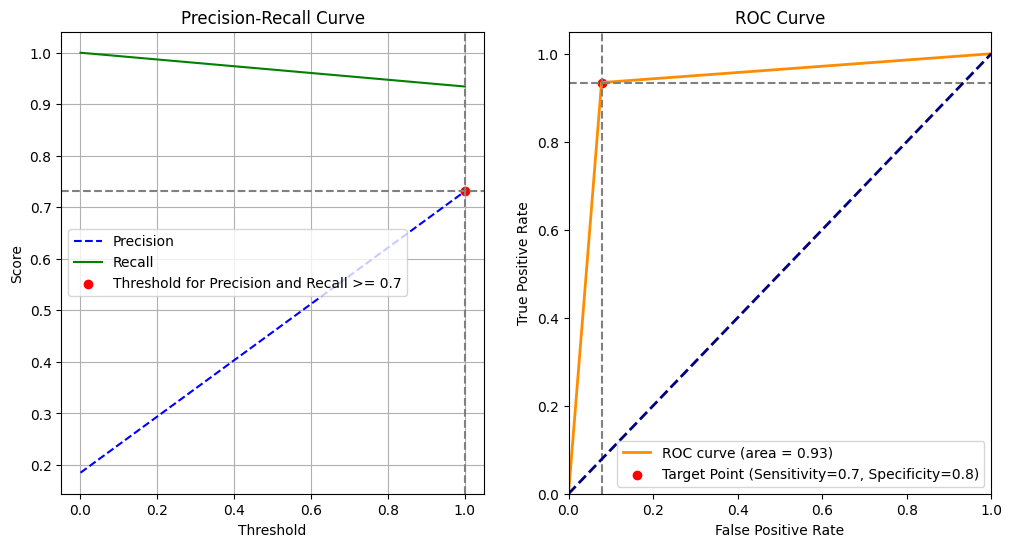

In [30]:
print("LSTM results: ")
evaluate_and_plot_metrics(lstm_model, X_train, y_train, X_test, y_test)

GRU results: 
3/3 [==============================] - 0s 8ms/step
Training Precision: 0.7307692307692307
Training Recall: 0.9344262295081968
Testing Precision: 0.375
Testing Recall: 0.46153846153846156
Roc score: 0.9281796575050277


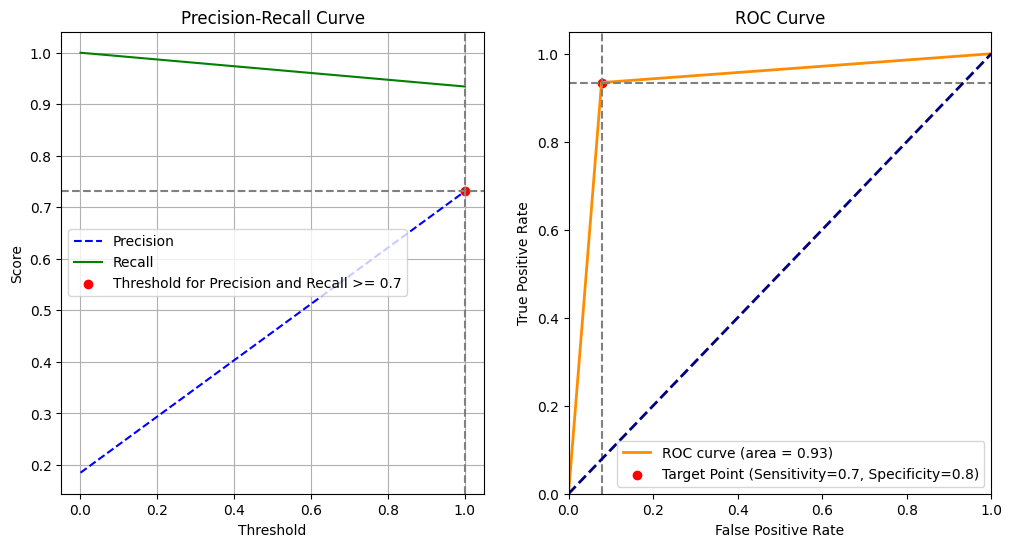

In [31]:
print("GRU results: ")
evaluate_and_plot_metrics(gru_model, X_train, y_train, X_test, y_test)

Bidirectional RNN results: 
3/3 [==============================] - 0s 8ms/step
Training Precision: 0.8461538461538461
Training Recall: 0.9016393442622951
Testing Precision: 0.4166666666666667
Testing Recall: 0.38461538461538464
Roc score: 0.932232311536352


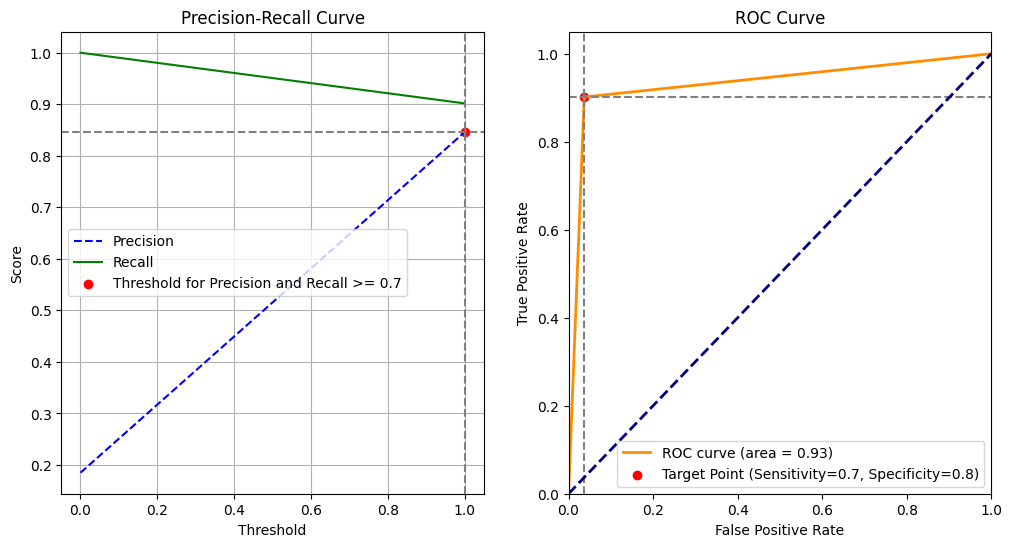

In [32]:
print("Bidirectional RNN results: ")
evaluate_and_plot_metrics(birnn_model, X_train, y_train, X_test, y_test)

3/3 [==============================] - 0s 5ms/step
GRU Model - Training Precision: 0.7307692307692307
GRU Model - Training Recall: 0.9344262295081968
GRU Model - Testing Precision: 0.375
GRU Model - Testing Recall: 0.46153846153846156
GRU Model - Roc score: 0.9281796575050277
3/3 [==============================] - 0s 6ms/step
LSTM Model - Training Precision: 0.7307692307692307
LSTM Model - Training Recall: 0.9344262295081968
LSTM Model - Testing Precision: 0.35294117647058826
LSTM Model - Testing Recall: 0.46153846153846156
LSTM Model - Roc score: 0.9281796575050277
3/3 [==============================] - 0s 5ms/step
BiRNN Model - Training Precision: 0.8461538461538461
BiRNN Model - Training Recall: 0.9016393442622951
BiRNN Model - Testing Precision: 0.4166666666666667
BiRNN Model - Testing Recall: 0.38461538461538464
BiRNN Model - Roc score: 0.932232311536352


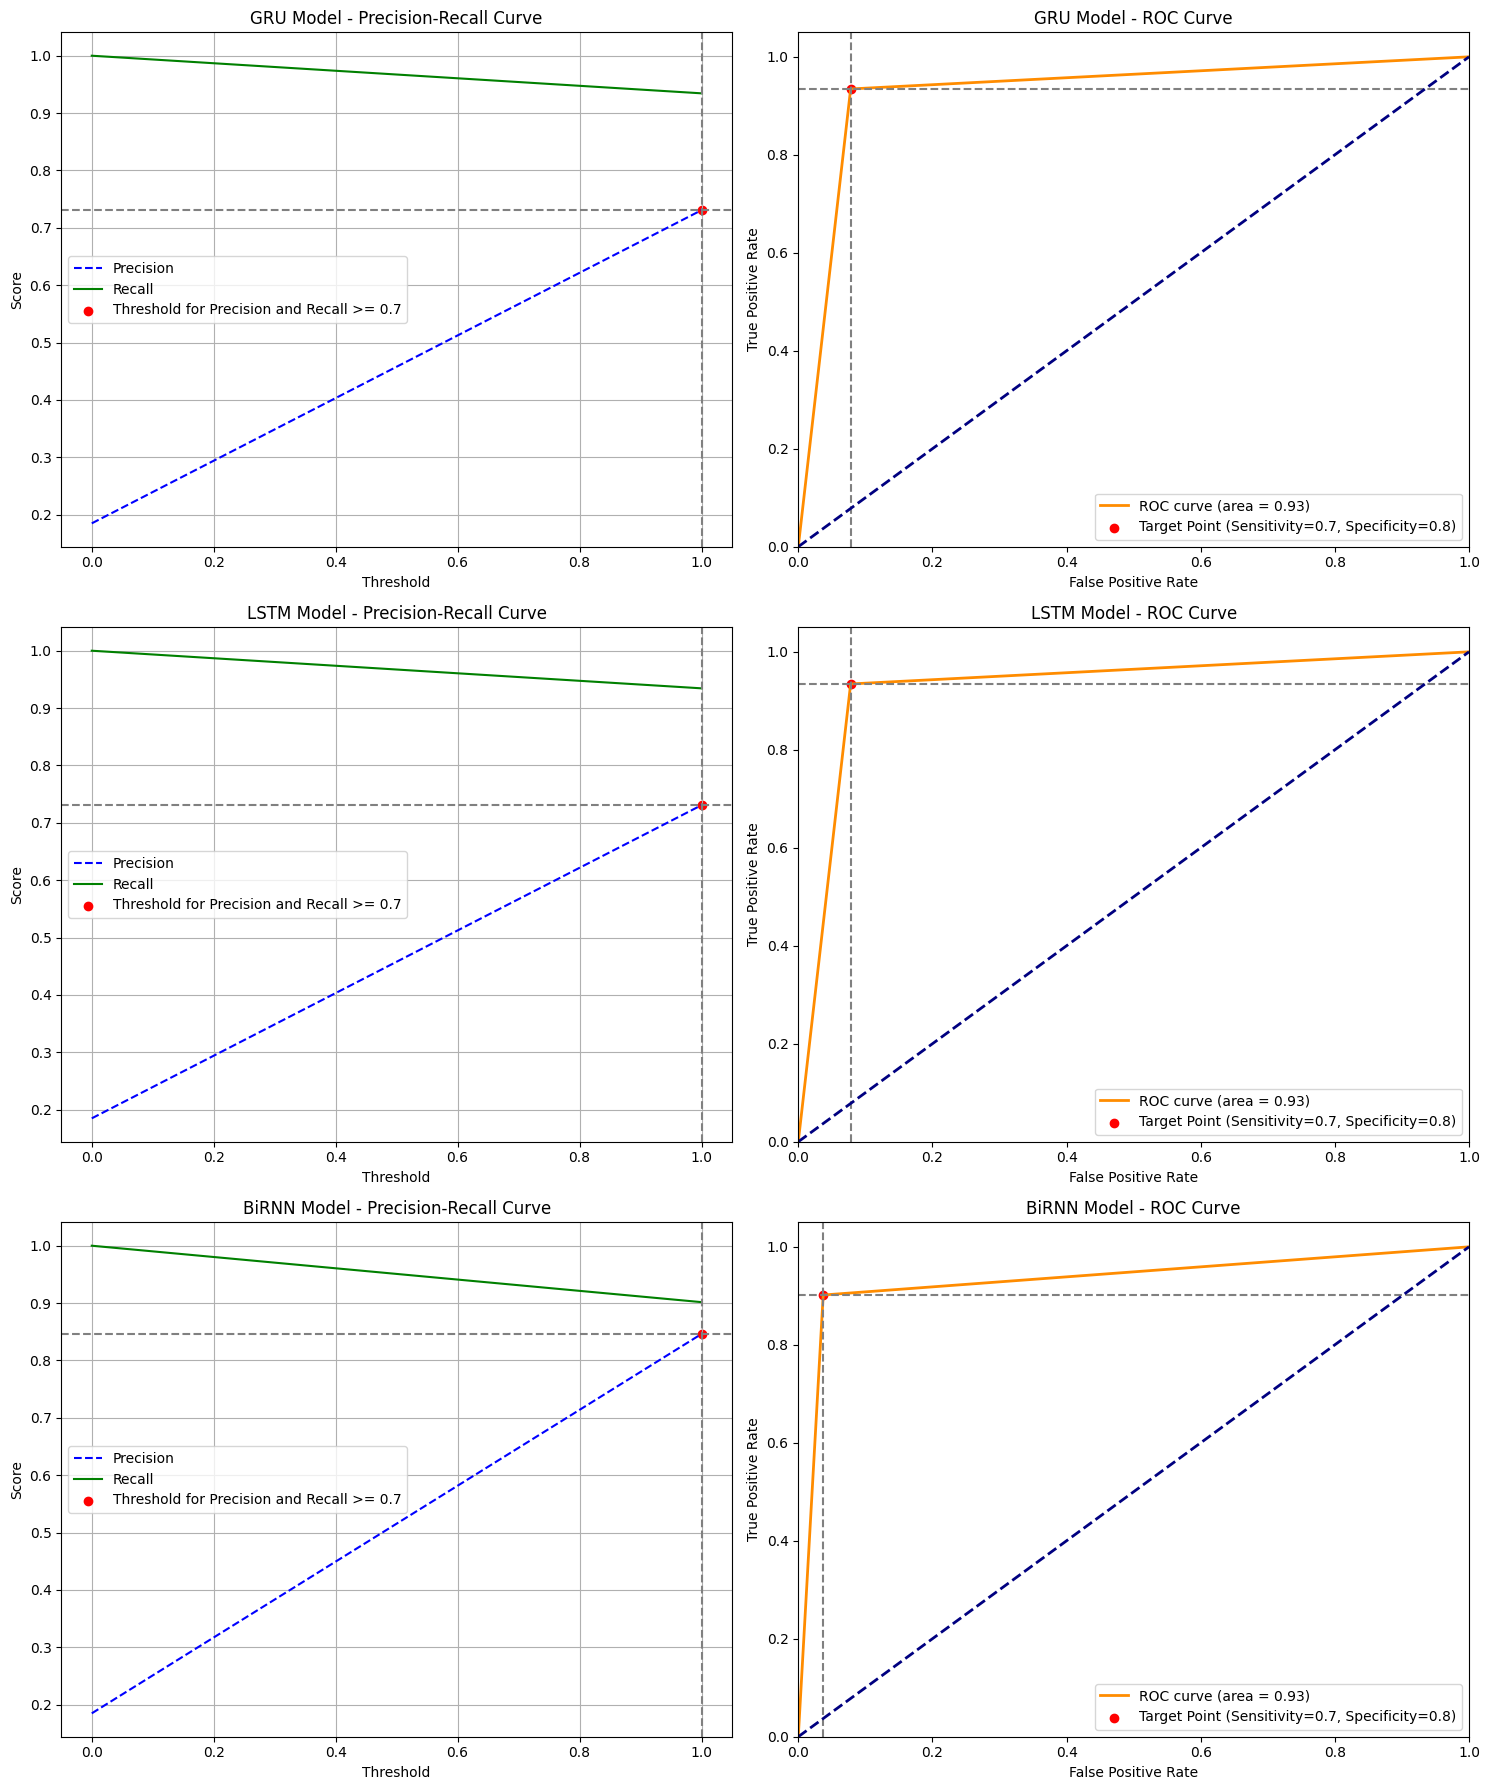

In [33]:
models_dict = {"GRU Model": gru_model, "LSTM Model": lstm_model, "BiRNN Model": birnn_model}
evaluate_and_plot_metrics_for_multiple_models_dict(models_dict, X_train, y_train, X_test, y_test)

In [ ]:
# loaded_lstm_model = tf.keras.models.load_model("lstm_model.h5")
# loaded_gru_model = tf.keras.models.load_model("gru_model.h5")
# loaded_birnn_model = tf.keras.models.load_model("birnn_model.h5")

In [ ]:
# models_dict = {"GRU Model": loaded_gru_model, "LSTM Model": loaded_lstm_model, "BiRNN Model": loaded_birnn_model}
# evaluate_and_plot_metrics_for_multiple_models_dict(models_dict, X_train, y_train, X_test, y_test)